# Imports 

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import functions as f

In [2]:
df = pd.read_csv('master_modeling.csv')

In [3]:
df.drop(columns=['Unnamed: 0'], inplace=True)

## Combining values for easier target varibale capture

In [4]:
# standardize the dataframes text
df.person_injury_severity = df.person_injury_severity.str.lower()
# combine values to make a more accurate target variable
df.loc[df['person_injury_severity'] == 'c - possible injury', 'person_injury_severity'] = 'b - suspected minor injury'
# drop all the instances where 99 is. inplace = true means to save the change 
df.drop(df.loc[df['person_injury_severity'] == '99 - unknown'].index, inplace=True)

In [5]:
# Trust but verify our code. 
df.person_injury_severity.value_counts()

person_injury_severity
b - suspected minor injury      8175
a - suspected serious injury    4006
n - not injured                 1155
k - fatal injury                 848
Name: count, dtype: int64

# Preprocessing

In [6]:
# First I want to see what my data looks like 
df.head()

,person_age,person_ethnicity,person_gender,has_motocycle_endorsment,person_injury_severity,vehicle_body_style,vehicle_color,vehicle_defect_1,vehicle_make,vehicle_model_name,vehicle_model_year
0,37,w - white,1 - male,0,a - suspected serious injury,mc - motorcycle,blu - blue,98 - other (explain in narrative),other (explain in narrative),other (explain in narrative) (other (explain i...,2007.0
1,30,h - hispanic,1 - male,0,b - suspected minor injury,mc - motorcycle,gry - gray,98 - other (explain in narrative),suzuki,gsx-r600 (suzuki),2004.0
2,21,w - white,1 - male,0,a - suspected serious injury,mc - motorcycle,blu - blue,98 - other (explain in narrative),yamaha,yzfr6 (yamaha),2017.0
3,18,h - hispanic,1 - male,0,b - suspected minor injury,mc - motorcycle,blu - blue,98 - other (explain in narrative),yamaha,rz500 (yamaha),2002.0
4,28,w - white,1 - male,1,b - suspected minor injury,mc - motorcycle,blk - black,98 - other (explain in narrative),harley-davidson,fxdf (harley-davidson),2009.0


    Takeaways:
    - My values will need to be converted to dummie variables
    - person_injury_severity is our targert variable and i dont want to encode that 
    

In [7]:
# Checking my dataframe infomartion to see what needs to be done 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14184 entries, 0 to 14183
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   person_age                14184 non-null  int64  
 1   person_ethnicity          14184 non-null  object 
 2   person_gender             14184 non-null  object 
 3   has_motocycle_endorsment  14184 non-null  int64  
 4   person_injury_severity    14184 non-null  object 
 5   vehicle_body_style        14184 non-null  object 
 6   vehicle_color             14184 non-null  object 
 7   vehicle_defect_1          14184 non-null  object 
 8   vehicle_make              14184 non-null  object 
 9   vehicle_model_name        14184 non-null  object 
 10  vehicle_model_year        14184 non-null  float64
dtypes: float64(1), int64(2), object(8)
memory usage: 1.2+ MB


In [8]:
object_cols = []
encoded_df = df.copy()

# Iterate over each column in the DataFrame
for col in df.columns:
    # Check if the column is of type 'object' and not the target column 'person_injury_severity'
    if df[col].dtype == 'object' and col != 'person_injury_severity':
        # Add the column name to the list of object columns
        object_cols.append(col)
        
        # Perform one-hot encoding using pd.get_dummies
        # drop_first=True drops the first category to avoid multicollinearity
        # prefix=col adds the column name as a prefix to the encoded columns
        # dtype=int sets the data type of the encoded columns to integer
        dummies = pd.get_dummies(data=df[col], columns=[col], drop_first=True, prefix=col, dtype=int)
        
        # Concatenate the encoded columns with the original DataFrame
        encoded_df = pd.concat([encoded_df, dummies], axis=1)
        
        # Drop the original categorical column from the encoded DataFrame
        encoded_df.drop(col, axis=1, inplace=True)

# Remove the target column 'person_injury_severity' from the encoded DataFrame
encoded_df = encoded_df[[col for col in encoded_df.columns if col != 'person_injury_severity']]

# Add the target column 'person_injury_severity' back to the encoded DataFrame
encoded_df['person_injury_severity'] = df['person_injury_severity']


In [9]:
encoded_df.head()

,person_age,has_motocycle_endorsment,vehicle_model_year,person_ethnicity_99 - unknown,person_ethnicity_a - asian,person_ethnicity_b - black,person_ethnicity_h - hispanic,person_ethnicity_i - amer. indian/alaskan native,person_ethnicity_w - white,person_gender_2 - female,...,vehicle_model_name_zx1002 (kawasaki),vehicle_model_name_zx1100 (kawasaki),vehicle_model_name_zx1200 (kawasaki),vehicle_model_name_zx1400 (kawasaki),vehicle_model_name_zx550 (kawasaki),vehicle_model_name_zx600 (kawasaki),vehicle_model_name_zx636 (kawasaki),vehicle_model_name_zx750 (kawasaki),vehicle_model_name_zx900 (kawasaki),person_injury_severity
0,37,0,2007.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,a - suspected serious injury
1,30,0,2004.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,b - suspected minor injury
2,21,0,2017.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,a - suspected serious injury
3,18,0,2002.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,b - suspected minor injury
4,28,1,2009.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,b - suspected minor injury


     This seems to be end of our preproceessing part

# Splitting the data 

In [10]:
# Split our data into train, validate and test
train, validate, test = f.split(encoded_df)

In [11]:
# split our values for modeling

x_train = train.drop(columns= 'person_injury_severity')
y_train = train['person_injury_severity']

x_validate = validate.drop(columns= 'person_injury_severity')
y_validate = validate['person_injury_severity']

x_test= test.drop(columns= 'person_injury_severity')
y_test = test['person_injury_severity']

# Make our baseline model

In [12]:
df.person_injury_severity.value_counts()

person_injury_severity
b - suspected minor injury      8175
a - suspected serious injury    4006
n - not injured                 1155
k - fatal injury                 848
Name: count, dtype: int64

    Since suspected minor injury occurs most often this will be our baseline

In [13]:
pred_df_train = pd.DataFrame()
pred_df_train['actual'] = y_train

In [14]:
pred_df_train['baseline_predictions'] = 'b - suspected minor injury' 

In [15]:
pred_df_train['baseline_predictions']

8812     b - suspected minor injury
4411     b - suspected minor injury
6370     b - suspected minor injury
13586    b - suspected minor injury
9801     b - suspected minor injury
                    ...            
740      b - suspected minor injury
11119    b - suspected minor injury
6639     b - suspected minor injury
6437     b - suspected minor injury
3381     b - suspected minor injury
Name: baseline_predictions, Length: 7942, dtype: object

In [16]:
pred_df_train.actual.value_counts()

actual
b - suspected minor injury      4620
a - suspected serious injury    2201
n - not injured                  655
k - fatal injury                 466
Name: count, dtype: int64

In [17]:
print(classification_report(pred_df_train['actual'],pred_df_train['baseline_predictions']))

                              precision    recall  f1-score   support

a - suspected serious injury       0.00      0.00      0.00      2201
  b - suspected minor injury       0.58      1.00      0.74      4620
            k - fatal injury       0.00      0.00      0.00       466
             n - not injured       0.00      0.00      0.00       655

                    accuracy                           0.58      7942
                   macro avg       0.15      0.25      0.18      7942
                weighted avg       0.34      0.58      0.43      7942



/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Descion Tree Classifier: Training

### make the model

In [18]:
clf = DecisionTreeClassifier(max_depth= 5, random_state= 666)

### Fit the model 

In [19]:
clf.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=5, random_state=666)

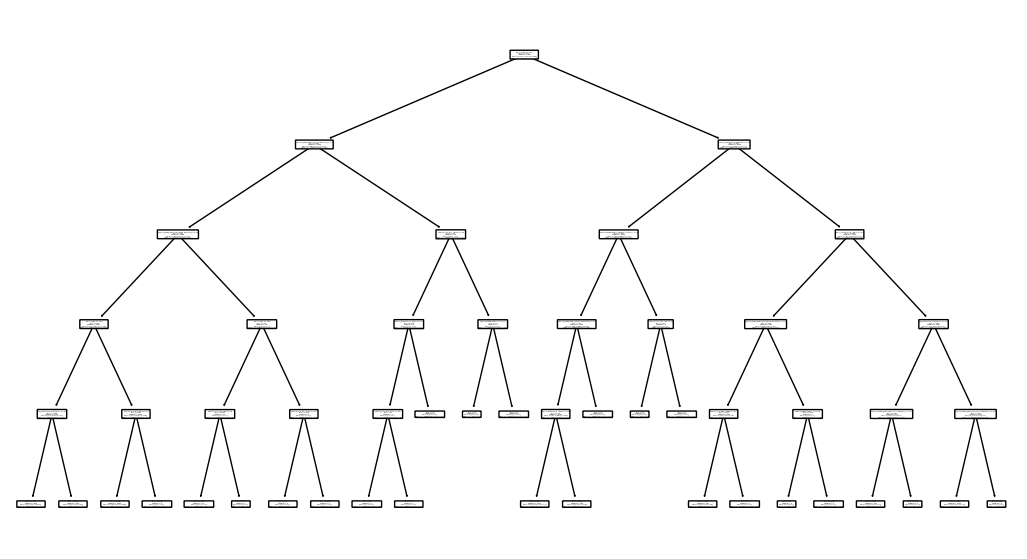

In [20]:
plt.figure(figsize=(13, 7))
plot_tree(clf, feature_names=x_train.columns, class_names=clf.classes_, rounded=True)
plt.show()

In [21]:
pred_df_train['clf_prediction'] = clf_pred = clf.predict(x_train)

In [22]:
pred_df_train

,actual,baseline_predictions,clf_prediction
8812,b - suspected minor injury,b - suspected minor injury,b - suspected minor injury
4411,b - suspected minor injury,b - suspected minor injury,b - suspected minor injury
6370,a - suspected serious injury,b - suspected minor injury,b - suspected minor injury
13586,b - suspected minor injury,b - suspected minor injury,b - suspected minor injury
9801,a - suspected serious injury,b - suspected minor injury,b - suspected minor injury
...,...,...,...
740,a - suspected serious injury,b - suspected minor injury,b - suspected minor injury
11119,b - suspected minor injury,b - suspected minor injury,b - suspected minor injury
6639,b - suspected minor injury,b - suspected minor injury,b - suspected minor injury
6437,b - suspected minor injury,b - suspected minor injury,b - suspected minor injury


In [23]:
print(classification_report(pred_df_train.actual,pred_df_train.clf_prediction))

                              precision    recall  f1-score   support

a - suspected serious injury       0.78      0.02      0.03      2201
  b - suspected minor injury       0.59      1.00      0.74      4620
            k - fatal injury       0.00      0.00      0.00       466
             n - not injured       0.83      0.02      0.04       655

                    accuracy                           0.59      7942
                   macro avg       0.55      0.26      0.20      7942
                weighted avg       0.63      0.59      0.44      7942



/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Descion Tree: Validate

In [30]:
val_pred= pd.DataFrame()

In [32]:
val_pred['actual'] = y_validate

In [35]:
val_pred['clf_prediction'] = clf.predict(x_validate)

In [36]:
print(classification_report(val_pred.actual,val_pred.clf_prediction))

                              precision    recall  f1-score   support

a - suspected serious injury       0.33      0.01      0.01       950
  b - suspected minor injury       0.58      0.99      0.73      1980
            k - fatal injury       0.00      0.00      0.00       215
             n - not injured       0.40      0.01      0.02       260

                    accuracy                           0.58      3405
                   macro avg       0.33      0.25      0.19      3405
                weighted avg       0.46      0.58      0.43      3405



/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# KNN: Training

In [24]:
knn = KNeighborsClassifier(n_neighbors=50, weights='uniform')
knn.fit(x_train, y_train)
pred_df_train['knn'] = knn.predict(x_train)
print(classification_report(pred_df_train.actual,pred_df_train.knn))

                              precision    recall  f1-score   support

a - suspected serious injury       0.49      0.06      0.11      2201
  b - suspected minor injury       0.59      0.98      0.74      4620
            k - fatal injury       0.00      0.00      0.00       466
             n - not injured       0.00      0.00      0.00       655

                    accuracy                           0.59      7942
                   macro avg       0.27      0.26      0.21      7942
                weighted avg       0.48      0.59      0.46      7942



/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Knn: Validate

In [37]:
val_pred['knn'] = knn.predict(x_validate)
print(classification_report(val_pred.actual,val_pred.knn))

                              precision    recall  f1-score   support

a - suspected serious injury       0.31      0.03      0.06       950
  b - suspected minor injury       0.58      0.97      0.73      1980
            k - fatal injury       0.00      0.00      0.00       215
             n - not injured       0.00      0.00      0.00       260

                    accuracy                           0.57      3405
                   macro avg       0.22      0.25      0.20      3405
                weighted avg       0.42      0.57      0.44      3405



/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Logistic Regression: Training

In [25]:
# First we get the weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
# make the model
logit = LogisticRegression(C=1, class_weight=dict(zip(np.unique(y_train), class_weights)), random_state=666, intercept_scaling=1, solver='lbfgs')
# fit the model
logit.fit(x_train, y_train)


LogisticRegression(C=1,
                   class_weight={'a - suspected serious injury': 0.9020899591094956,
                                 'b - suspected minor injury': 0.4297619047619048,
                                 'k - fatal injury': 4.260729613733906,
                                 'n - not injured': 3.031297709923664},
                   random_state=666)

In [26]:
# check the intercepts and the coefficients of the logistic regression model
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)


Coefficient: 
 [[ 3.65215252e-03 -2.37441146e-01 -7.36552420e-05 ...  2.60948290e-03
   1.05533848e-03  1.34243623e-03]
 [-6.55799027e-03  3.29973646e-02  1.70069688e-04 ... -9.21175361e-03
   1.91832360e-03  1.04562415e-03]
 [ 1.35684682e-02 -1.20314525e-01 -3.58970615e-04 ... -6.59136464e-04
  -1.24995810e-03 -9.99344136e-04]
 [-1.06626304e-02  3.24758306e-01  2.62556169e-04 ...  7.26140717e-03
  -1.72370398e-03 -1.38871624e-03]]
Intercept: 
 [ 0.00069797  0.00080218 -0.00111189 -0.00038826]


In [27]:
# make predictions 
pred_df_train['logistic'] = logit.predict(x_train)

In [28]:
print(classification_report(pred_df_train['actual'], pred_df_train['logistic']))

                              precision    recall  f1-score   support

a - suspected serious injury       0.33      0.20      0.25      2201
  b - suspected minor injury       0.64      0.26      0.37      4620
            k - fatal injury       0.09      0.47      0.16       466
             n - not injured       0.11      0.40      0.17       655

                    accuracy                           0.27      7942
                   macro avg       0.29      0.33      0.24      7942
                weighted avg       0.48      0.27      0.31      7942



# 

# Our Models Traing Score

In [29]:
for cols in pred_df_train.columns:
    if (pred_df_train[cols] != pred_df_train['actual']).any():
        print(f'classification report for {cols}:')
        print('=====================================')
        print(classification_report(pred_df_train['actual'], pred_df_train[cols]))
    else:
        print(f"The {cols} column matches the 'actual' column.")


The actual column matches the 'actual' column.
classification report for baseline_predictions:
                              precision    recall  f1-score   support

a - suspected serious injury       0.00      0.00      0.00      2201
  b - suspected minor injury       0.58      1.00      0.74      4620
            k - fatal injury       0.00      0.00      0.00       466
             n - not injured       0.00      0.00      0.00       655

                    accuracy                           0.58      7942
                   macro avg       0.15      0.25      0.18      7942
                weighted avg       0.34      0.58      0.43      7942

classification report for clf_prediction:
                              precision    recall  f1-score   support

a - suspected serious injury       0.78      0.02      0.03      2201
  b - suspected minor injury       0.59      1.00      0.74      4620
            k - fatal injury       0.00      0.00      0.00       466
             n - no

/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/l

                              precision    recall  f1-score   support

a - suspected serious injury       0.49      0.06      0.11      2201
  b - suspected minor injury       0.59      0.98      0.74      4620
            k - fatal injury       0.00      0.00      0.00       466
             n - not injured       0.00      0.00      0.00       655

                    accuracy                           0.59      7942
                   macro avg       0.27      0.26      0.21      7942
                weighted avg       0.48      0.59      0.46      7942

classification report for logistic:
                              precision    recall  f1-score   support

a - suspected serious injury       0.33      0.20      0.25      2201
  b - suspected minor injury       0.64      0.26      0.37      4620
            k - fatal injury       0.09      0.47      0.16       466
             n - not injured       0.11      0.40      0.17       655

                    accuracy                     

/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
